In [1]:
import tensorflow as tf
from functools import partial
import keras
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt
import os

In [2]:
## utility functions
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

def crop(images):
    return images[150:220, 130:250]

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Convolution Example

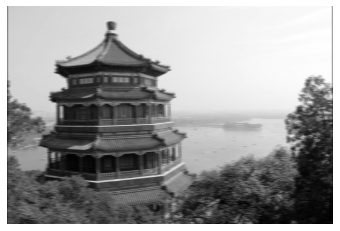

In [3]:
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

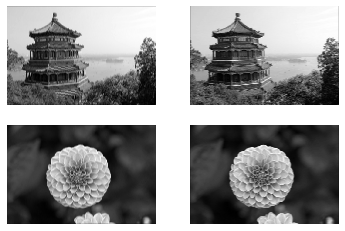

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

Saving figure china_original


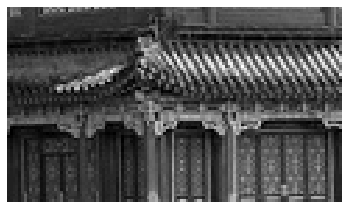

Saving figure china_vertical


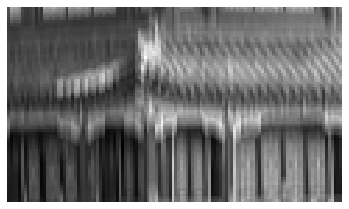

Saving figure china_horizontal


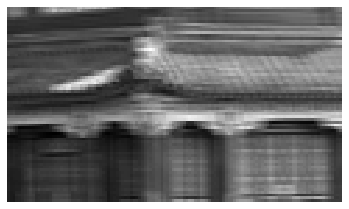

In [5]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

## Implementing ResNet-34 CNN using Keras

### Residual Unit

In [6]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

### Model

In [7]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 56, 56, 64)        7

## Using Pretrained Models from Keras
In general, you won’t have to implement standard models like GoogLeNet or ResNet manually, since pretrained networks are readily available with a single line of code in the keras.applications package. For example, you can load the ResNet-50 model, pretrained on ImageNet, with the following line of code:

In [8]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 3s 0us/step


This will create a ResNet-50 model and download weights pretrained on the ImageNet dataset. To use it, you first need to ensure that the images have the right size. A ResNet-50 model expects 224 × 224-pixel images (other models may expect other sizes, such as 299 × 299), so let’s use TensorFlow’s tf.image.resize() function to resize the images we loaded earlier:

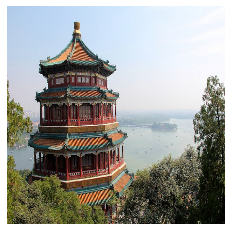

In [9]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
# plot_color_image(images_resized[1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


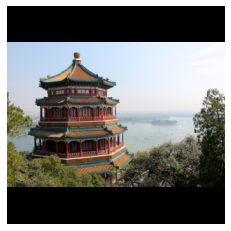

In [10]:
# The tf.image.resize() will not preserve the aspect ratio. 
# If this is a problem, try cropping the images to the appropriate aspect ratio 
# before resizing. Both operations can be done in one shot with tf.image.crop_and_resize().
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

The pretrained models assume that the images are preprocessed in a specific way. In some cases they may expect the inputs to be scaled from 0 to 1, or –1 to 1, and so on. Each model provides a preprocess_input() function that you can use to preprocess your images. These functions assume that the pixel values range from 0 to 255, so we must multiply them by 255 (since earlier we scaled them to the 0–1 range):

In [11]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [12]:
# prediction
Y_proba = model.predict(inputs)
print(Y_proba)

[[5.2653163e-06 3.7641755e-06 1.3319053e-06 ... 2.1388647e-07
  4.5047291e-06 6.1290375e-06]
 [1.4558026e-07 7.2859100e-04 3.2788676e-06 ... 8.6971959e-05
  1.9637733e-03 1.7987133e-04]]


As usual, the output Y_proba is a matrix with one row per image and one column per class (in this case, there are 1,000 classes). If you want to display the top K predictions, including the class name and the estimated probability of each predicted class, use the decode_predictions() function. For each image, it returns an array containing the top K predictions, where each prediction is represented as an array containing the class identifier,23 its name, and the corresponding confidence score:

In [13]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

40960/35363 [==================================] - 0s 0us/step
Image #0
 n03028079 - church       26.16%
 n04346328 - stupa        23.96%
 n02980441 - castle       17.40%

Image #1
 n11939491 - daisy        15.94%
 n03530642 - honeycomb    15.29%
 n04522168 - vase         9.32%



## Pretrained Models for Transfer Learning
If you want to build an image classifier but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model. For example, let’s train a model to classify pictures of flowers, reusing a pretrained Xception model. First, let’s load the dataset using TensorFlow Datasets

### import dataset

In [14]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
print(f"dataset_size = {dataset_size}")
class_names = info.features["label"].names
print(f"class_names = {class_names}")
n_classes = info.features["label"].num_classes
print(f"n_classes = {n_classes}")

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.
dataset_size = 3670
class_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
n_classes = 5


Note that you can get information about the dataset by setting with_info=True. Here, we get the dataset size and the names of the classes. Unfortunately, there is only a "train" dataset, no test set or validation set, so we need to split the training set. The TF Datasets project provides an API for this. For example, let’s take the first 10% of the dataset for testing, the next 15% for validation, and the remaining 75% for training:

In [15]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

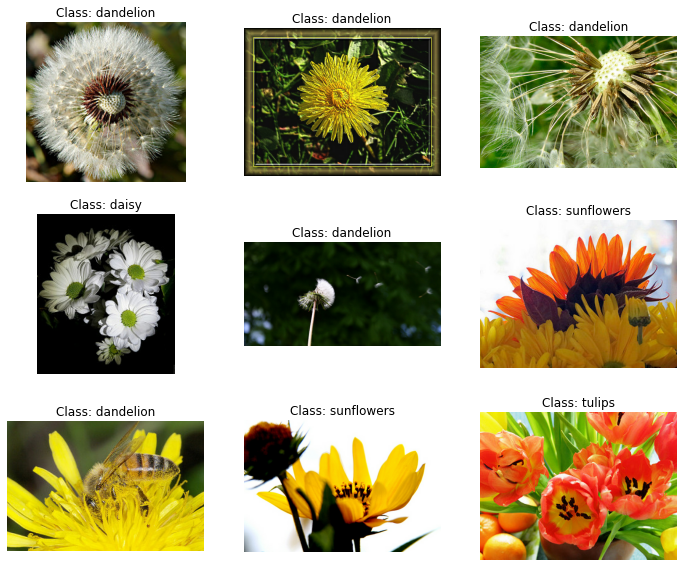

In [16]:
# plot some examples
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

### Preprocess dataset

In [17]:
# simple preprocessing
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [18]:
# fancier preprocessing
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# shuffle, preprocess, and batch dataset
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

Next let’s load an Xception model, pretrained on ImageNet. We exclude the top of the network by setting include_top=False: this excludes the global average pooling layer and the dense output layer. We then add our own global average pooling layer, based on the output of the base model, followed by a dense output layer with one unit per class, using the softmax activation function. Finally, we create the Keras Model:

### Load and train model

In [19]:
base_model = keras.applications.xception.Xception(weights="imagenet",
include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

# freeze basemodel layers weights
for layer in base_model.layers:
    layer.trainable = False

model.summary()

83689472/83683744 [==============================] - 2s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________

In [21]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 35s 403ms/step - loss: 0.1600 - accuracy: 0.9473 - val_loss: 0.5552 - val_accuracy: 0.8824
Epoch 2/5
86/86 [==============================] - 34s 394ms/step - loss: 0.1156 - accuracy: 0.9568 - val_loss: 0.7904 - val_accuracy: 0.8603
Epoch 3/5
86/86 [==============================] - 34s 394ms/step - loss: 0.0765 - accuracy: 0.9724 - val_loss: 0.6277 - val_accuracy: 0.8768
Epoch 4/5
86/86 [==============================] - 34s 393ms/step - loss: 0.0649 - accuracy: 0.9760 - val_loss: 0.5591 - val_accuracy: 0.8897
Epoch 5/5
86/86 [==============================] - 34s 395ms/step - loss: 0.0651 - accuracy: 0.9775 - val_loss: 0.5265 - val_accuracy: 0.8971


In [22]:
import pandas as pd

train_df = pd.DataFrame(history.history)
train_df

,loss,accuracy,val_loss,val_accuracy
0,0.159976,0.947311,0.555187,0.882353
1,0.115612,0.956759,0.790352,0.860294
2,0.076492,0.972384,0.627715,0.876838
3,0.064938,0.976017,0.559133,0.889706
4,0.065150,0.977471,0.526505,0.897059


After training the model for a few epochs, its validation accuracy should reach about 75–80% and stop making much progress. This means that the top layers are now pretty well trained, so we are ready to unfreeze all the layers (or you could try unfreezing just the top ones) and continue training (don’t forget to compile the model when you freeze or unfreeze layers). This time we use a much lower learning rate to avoid damaging the pretrained weights:

In [23]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
 2/86 [..............................] - ETA: 54s - loss: 0.4691 - accuracy: 0.8125WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3448s vs `on_train_batch_end` time: 0.9620s). Check your callbacks.


86/86 [==============================] - 117s 1s/step - loss: 0.3408 - accuracy: 0.8859 - val_loss: 1.1038 - val_accuracy: 0.7904
Epoch 2/40
86/86 [==============================] - 117s 1s/step - loss: 0.1192 - accuracy: 0.9629 - val_loss: 0.3039 - val_accuracy: 0.9099
Epoch 3/40
86/86 [==============================] - 117s 1s/step - loss: 0.0583 - accuracy: 0.9815 - val_loss: 0.2918 - val_accuracy: 0.9136
Epoch 4/40
86/86 [==============================] - 117s 1s/step - loss: 0.0422 - accuracy: 0.9887 - val_loss: 0.2594 - val_accuracy: 0.9283
Epoch 5/40
86/86 [==============================] - 117s 1s/step - loss: 0.0221 - accuracy: 0.9931 - val_loss: 0.3036 - val_accuracy: 0.9320
Epoch 6/40
86/86 [==============================] - 117s 1s/step - loss: 0.0332 - accuracy: 0.9891 - val_loss: 0.2950 - val_accuracy: 0.9283
Epoch 7/40
86/86 [==============================] - 117s 1s/step - loss: 0.0153 - accuracy: 0.9953 - val_loss: 0.2953 - val_accuracy: 0.9191
Epoch 8/40
86/86 [======

## Classification and Localization
Localizing an object in a picture can be expressed as a regression task a common approach is to predict the horizontal and vertical coordinates of the object’s center, as well as its height and width. This means we have four numbers to predict. It does not require much change to the model; we just need to add a second dense output layer with four units (typically on top of the global average pooling layer), and it can be trained using the MSE loss:

In [24]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

Let’s suppose you’ve obtained the bounding boxes for every image in the flowers dataset (for now we will assume there is a single bounding box per image). You then need to create a dataset whose items will be batches of preprocessed images along with their class labels and their bounding boxes. Each item should be a tuple of the form (images, (class_labels, bounding_boxes)). Then you are ready to train your model!

In [25]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

The MSE often works fairly well as a cost function to train the model, but it is not a great metric to evaluate how well the model can predict bounding boxes. The most common metric for this is the **Intersection over Union (IoU)**: the area of overlap between the predicted bounding box and the target bounding box, divided by the area of their union. In tf.keras, it is implemented by the tf.keras.metrics.MeanIoU class.

In [26]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
2/5 [===========>..................] - ETA: 3s - loss: 1.3795 - dense_2_loss: 1.6535 - dense_3_loss: 0.2838 - dense_2_accuracy: 0.1094 - dense_3_accuracy: 0.3438WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3382s vs `on_train_batch_end` time: 0.9674s). Check your callbacks.


5/5 [==============================] - 6s 1s/step - loss: 1.3699 - dense_2_loss: 1.6386 - dense_3_loss: 0.2955 - dense_2_accuracy: 0.1187 - dense_3_accuracy: 0.2937
Epoch 2/2
5/5 [==============================] - 6s 1s/step - loss: 1.3055 - dense_2_loss: 1.5633 - dense_3_loss: 0.2745 - dense_2_accuracy: 0.3125 - dense_3_accuracy: 0.2000


In [ ]:
model.predict()